In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ride_data = pd.read_csv('train_set.csv')

/Users/adiv/opt/anaconda3/envs/dsfs/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Una vez que se hizo una exploración de los datos (ver notebook Arkon_test_data_exploration) aquí vamos a preparalos para crear el modelo.

In [5]:
ride_data['passholder_type'].value_counts()

Monthly Pass    394769
Walk-up         212426
One Day Pass     44455
Annual Pass      34092
Flex Pass        11604
Testing             78
Name: passholder_type, dtype: int64

In [6]:
ride_data['trip_route_category'].value_counts()

One Way       582076
Round Trip    117924
Name: trip_route_category, dtype: int64

In [13]:
#Quitemos todas las filas de todas las columnas que contengan coordenadas incorrectas
ride_data.drop(ride_data[ride_data['start_lon'] > -100].index, inplace = True)
ride_data.drop(ride_data[ride_data['end_lon'] > -100].index, inplace = True)
ride_data.drop(ride_data[ride_data['start_lat'] > 35].index, inplace = True)
ride_data.drop(ride_data[ride_data['end_lat'] > 35].index, inplace = True)

Vamos a transformar las fechas a date objects

In [11]:
from datetime import datetime
import dateutil.parser

In [12]:
ride_data['start_time'] = ride_data['start_time'].apply(dateutil.parser.parse)
ride_data['end_time'] = ride_data['end_time'].apply(dateutil.parser.parse)

Veamos como se distribuye la duración de los viajes para todos los usuarios.

In [ ]:
#Aquí debí haber hecho un ajuste a una power law y ver si realmente ajustaba.

<AxesSubplot:>

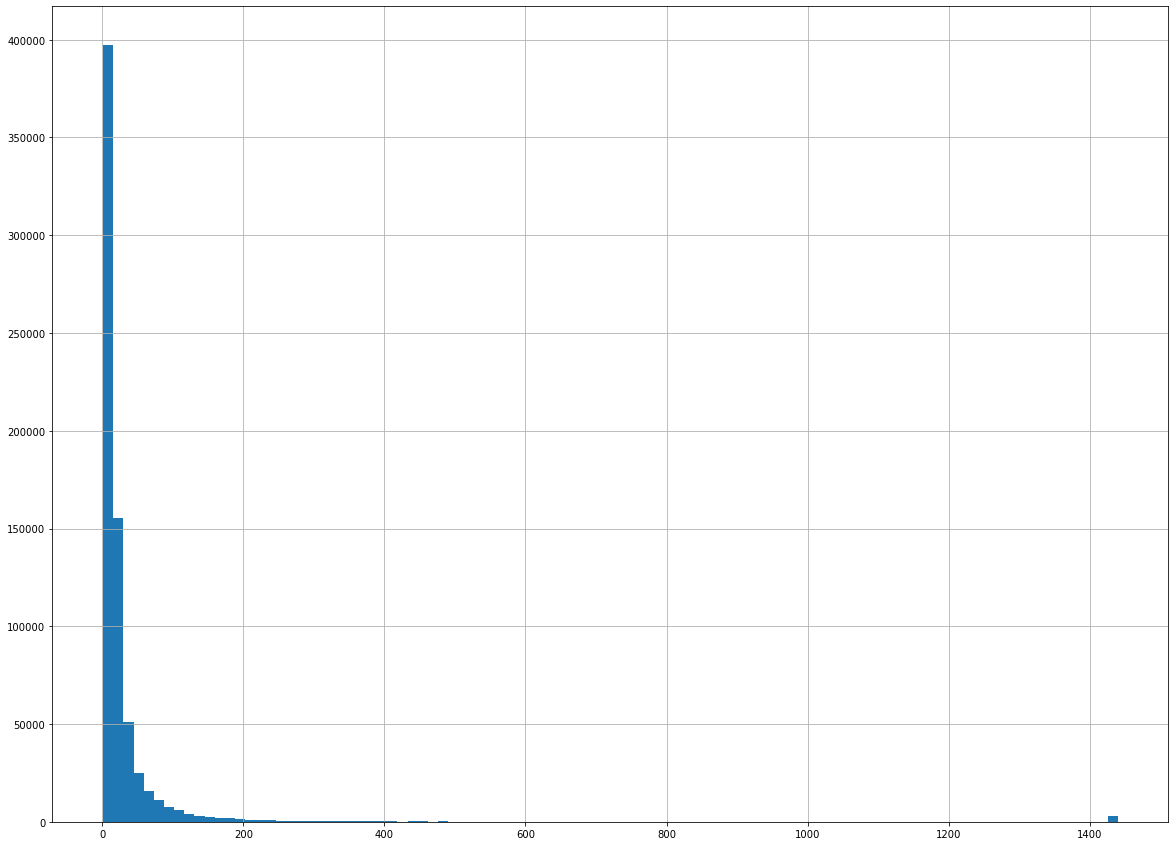

In [14]:
ride_data['duration'].hist(bins=100, figsize=(20,15))

En el plot de duración de los viajes pareciera una ley de potencias, excepto unos puntos con más de 1400 minutos.
Veamos más de cerca esos puntos

<AxesSubplot:>

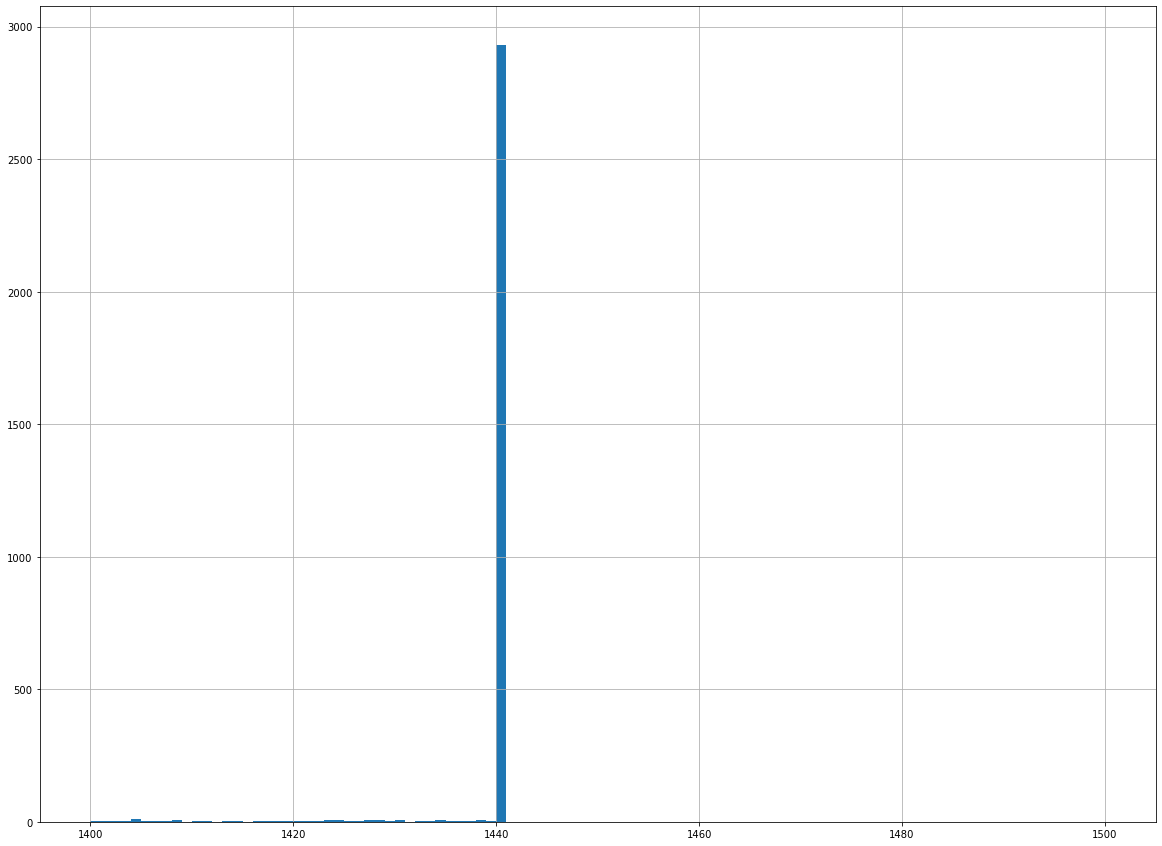

In [15]:
ride_data['duration'].hist(bins=100, figsize=(20,15), range=(1400, 1500))

1440 min son 24 horas. Estos datos lo más probable es que correspondan a viajes donde la bicicleta fue abandonada, mal instalada en una estación o robada. Los vamos a remover

In [16]:
ride_data.drop(ride_data[ride_data['duration'] >= 1440].index, inplace = True)

Para alimentar el modelo vamos a convertir los tiempos de inicio y de final a días julianos.

In [17]:
ride_data['start_time'] = pd.DatetimeIndex(ride_data['start_time']).to_julian_date()
ride_data['end_time'] = pd.DatetimeIndex(ride_data['end_time']).to_julian_date()

El bike_id es un string, entonces se tiene que convertir en un int o float.

In [18]:
ride_data['bike_id'] = pd.to_numeric(ride_data['bike_id'],errors='coerce')

In [19]:
ride_data.isna().sum()

trip_id                    0
duration                   0
start_time                 0
end_time                   0
start_lat               5532
start_lon               5532
end_lat                16591
end_lon                16591
bike_id                   17
plan_duration            208
trip_route_category        0
passholder_type         2574
start_station              0
end_station                0
dtype: int64

De entrada se pueden borrar los NaN de passholder_type, ya que es categórico. También de bike_id ya que se supone que es un id único. Plan_duration también es una variable discreta, entonces no se podría aplicar una estrategia como llenar los NaN con el promedio.

In [20]:
ride_data = ride_data.dropna(subset = ['bike_id','plan_duration','passholder_type'])

Antes de decidir que hacer con los NaN de posición (latitude and longitude) voy a calcular la distancia entre puntos y ver como se distribuye

In [21]:
ride_data['distance'] = np.sqrt((ride_data['end_lon']-ride_data['start_lon'])*(ride_data['end_lon']-ride_data['start_lon'])
                             +(ride_data['end_lat']-ride_data['start_lat'])*(ride_data['end_lat']-ride_data['start_lat']))

/Users/adiv/opt/anaconda3/envs/dsfs/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:>

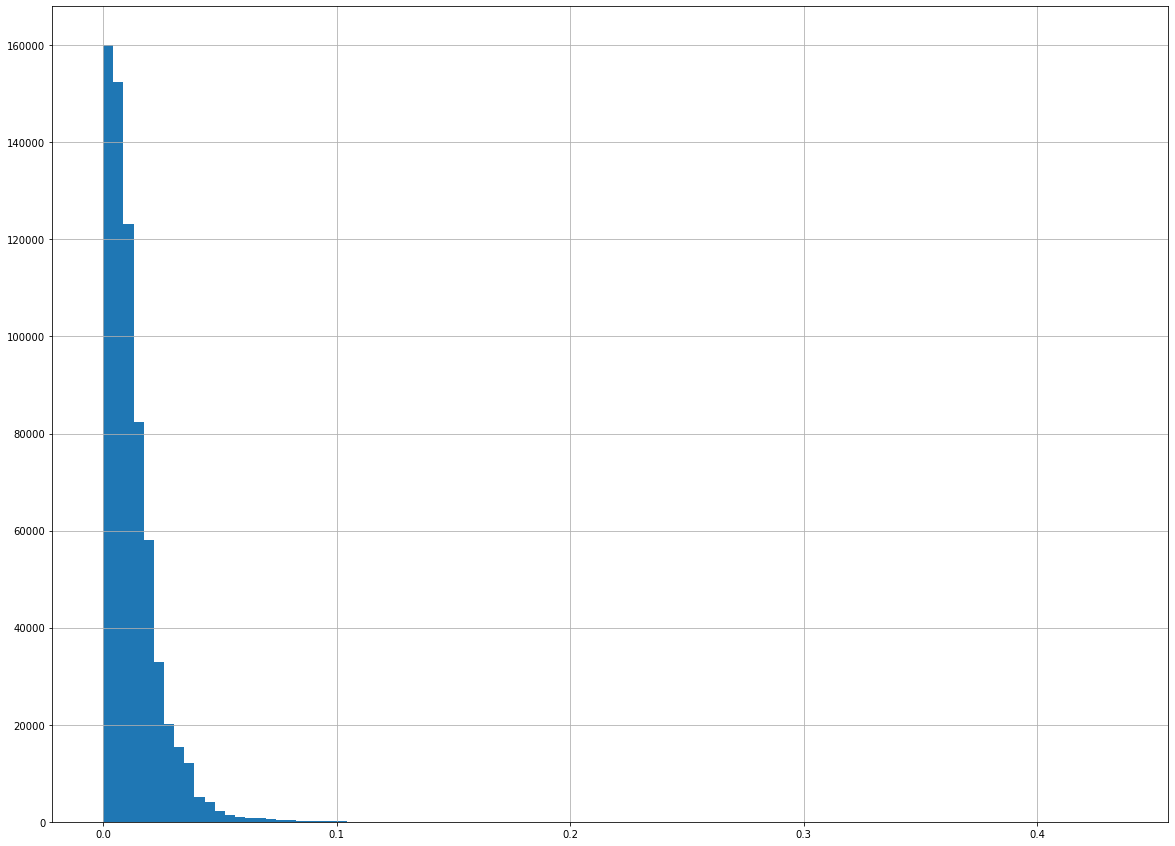

In [22]:
ride_data['distance'].hist(bins=100, figsize=(20,15))

Copiemos las variables de posición en una nueva dataframe

In [23]:
pos_var=ride_data[['start_lat','start_lon','end_lat','end_lon']] 

In [24]:
from sklearn.impute import SimpleImputer

In [25]:
imputer = SimpleImputer(missing_values=np.nan,strategy="most_frequent")
imputer.fit(pos_var)
pos_var_imp = imputer.transform(pos_var)
pos_var = pd.DataFrame(pos_var_imp, columns=pos_var.columns)

Vuelvo a calcular la distancias y veo como se distribuyen

<AxesSubplot:>

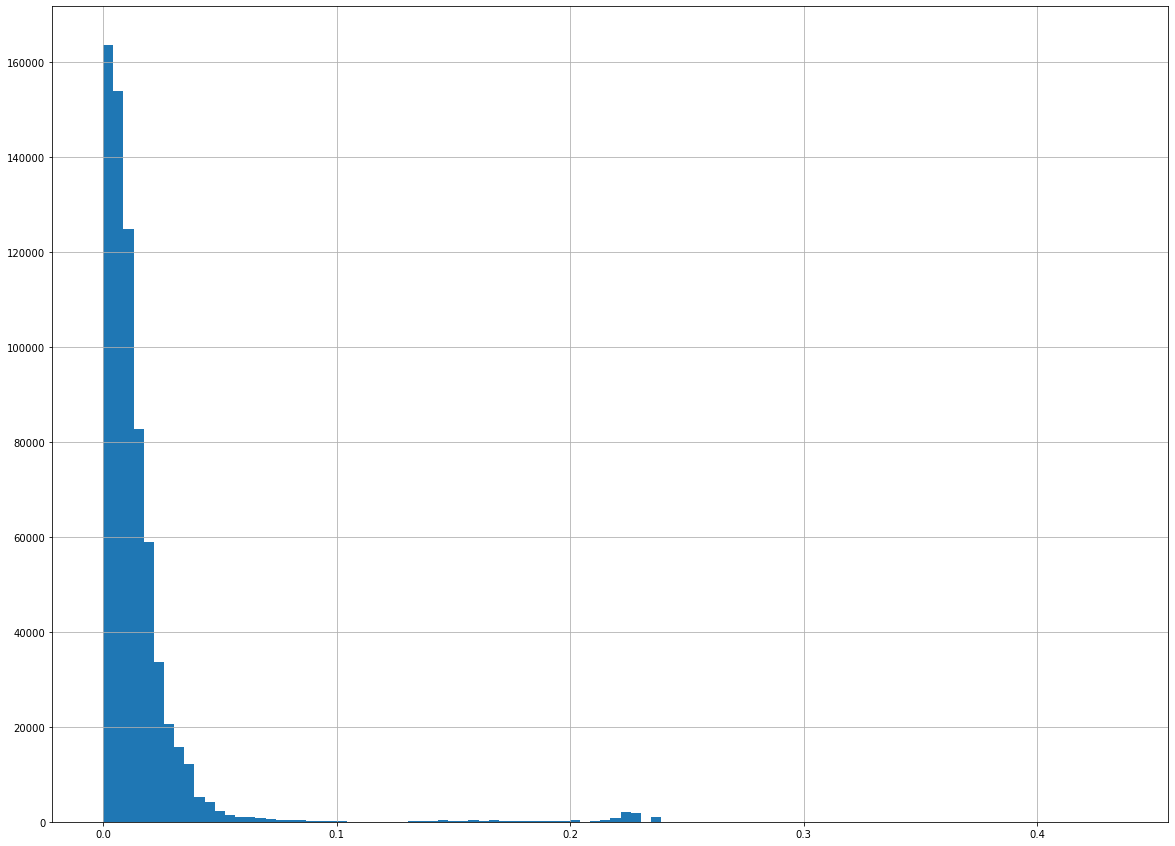

In [26]:
pos_var['distance'] = np.sqrt((pos_var['end_lon']-pos_var['start_lon'])*(pos_var['end_lon']-pos_var['start_lon'])
                             +(pos_var['end_lat']-pos_var['start_lat'])*(pos_var['end_lat']-pos_var['start_lat']))
pos_var['distance'].hist(bins=100, figsize=(20,15))

Al final de la distribución aparecen unos puntos que no aparecían antes de introducir los valores de moda, lo cual podría introducir un artificio al algoritmo de ML, sobre todo porque parecieran ser distancias largas. Chequemos si utilizando otra estrategia apareza de nuevo el artificio.

<AxesSubplot:>

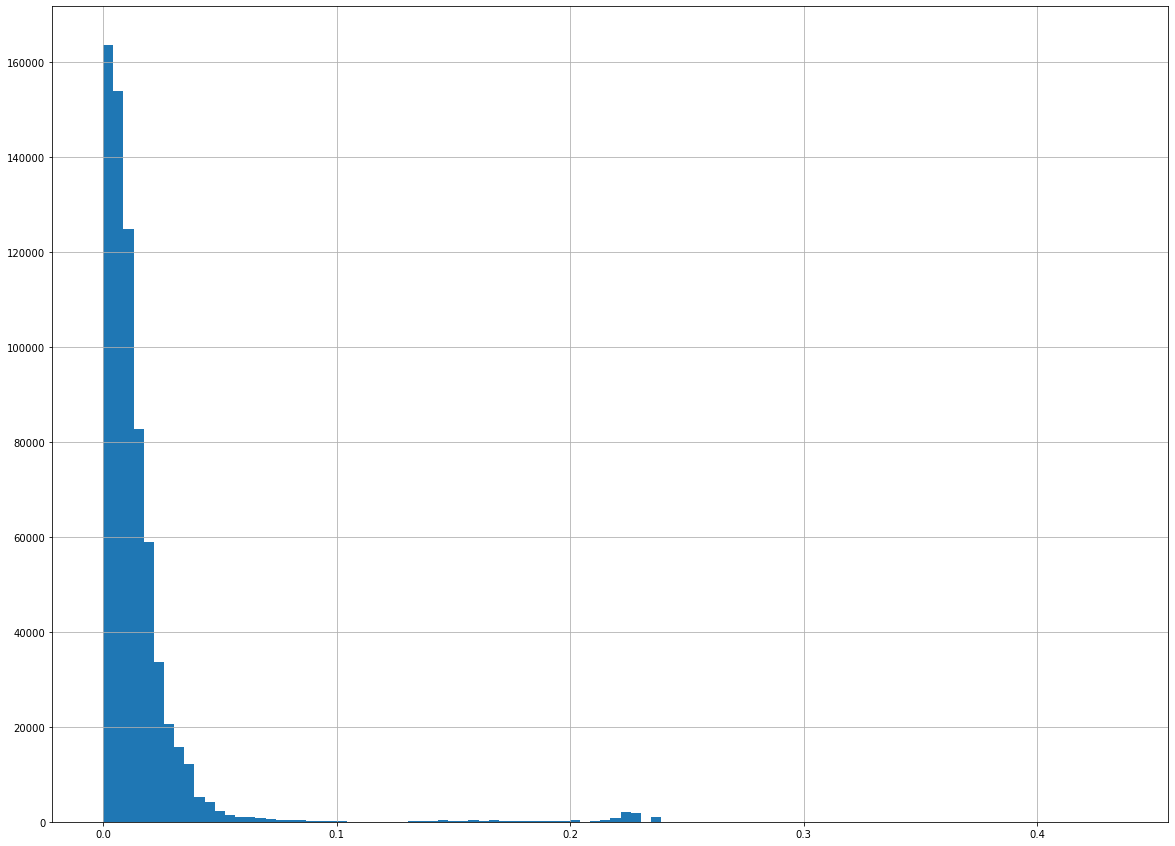

In [27]:
imputer = SimpleImputer(missing_values=np.nan,strategy="median")
imputer.fit(pos_var)
pos_var_imp = imputer.transform(pos_var)
pos_var = pd.DataFrame(pos_var_imp, columns=pos_var.columns)
pos_var['distance'] = np.sqrt((pos_var['end_lon']-pos_var['start_lon'])*(pos_var['end_lon']-pos_var['start_lon'])
                             +(pos_var['end_lat']-pos_var['start_lat'])*(pos_var['end_lat']-pos_var['start_lat']))
pos_var['distance'].hist(bins=100, figsize=(20,15))

De nuevo se ven puntos que podrían confundir el modelo. Finalmente probabos con el promedio "mean".

<AxesSubplot:>

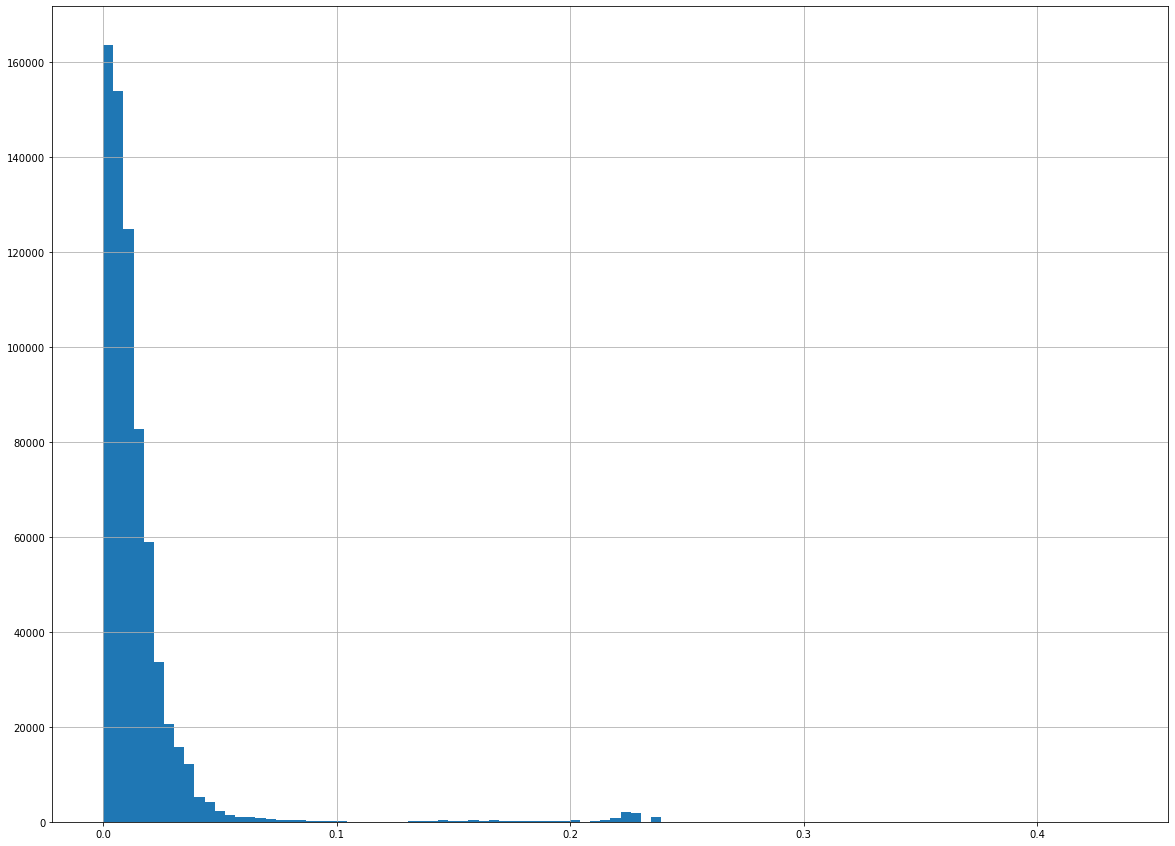

In [28]:
imputer = SimpleImputer(missing_values=np.nan,strategy="mean")
imputer.fit(pos_var)
pos_var_imp = imputer.transform(pos_var)
pos_var = pd.DataFrame(pos_var_imp, columns=pos_var.columns)
pos_var['distance'] = np.sqrt((pos_var['end_lon']-pos_var['start_lon'])*(pos_var['end_lon']-pos_var['start_lon'])
                             +(pos_var['end_lat']-pos_var['start_lat'])*(pos_var['end_lat']-pos_var['start_lat']))
pos_var['distance'].hist(bins=100, figsize=(20,15))

También aparecen esos puntos sospechosos. Dado que el grupo de datos con NaN es pequeño (menos del 3% del total) lo mejor es removerlos.

In [29]:
ride_data = ride_data.dropna(subset = ['start_lat','start_lon','end_lat','end_lon'])

Para los datos categóricos de trip_rout_category y passholder_type vamos a utilizar el OrdinalEncoder

In [30]:
#Cardinal codification
from sklearn.preprocessing import OrdinalEncoder

In [31]:
ordinal_encoder_trip = OrdinalEncoder()
ordinal_encoder_pass = OrdinalEncoder()
ride_data['trip_route_category'] = ordinal_encoder_trip.fit_transform(ride_data[['trip_route_category']])
ride_data['passholder_type'] = ordinal_encoder_pass.fit_transform(ride_data[['passholder_type']])

Aunque ya se provee una muestra de prueba, en caso de que no hubiera, lo que tendría que hacer es hacer shuffle y separar las muestras de prueba y de entrenamiento pero de forma estratificada, para tener una muestra de cada categoría de la columna "passholder_type".

In [33]:
ride_data = ride_data.reset_index(drop=True)

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit

In [35]:
#Dividimos los datos siguiendo la distribución de Passholder
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(ride_data, ride_data['passholder_type']):
        train_set = ride_data.loc[train_index]
        test_set = ride_data.loc[test_index]

Los datos de entrenamiento vamos a dividirlos en predictores y targets y estandarizar los predictores

In [50]:
train_X = train_set.drop('passholder_type', axis=1)
train_y = train_set['passholder_type'].copy()

In [37]:
from sklearn.preprocessing import StandardScaler

In [51]:
std_scaler = StandardScaler()
scaled = std_scaler.fit_transform(train_X)
train_X_scaled = pd.DataFrame(scaled, columns=train_X.columns)

In [ ]:
#Hacer pruebas con otros escaladores. Al hacer estandarización tal vez se borró la información de las distribuciones temporales.
#El Min-Max scaler probablemente hubiera funcionado mejor.

In [39]:
train_X_scaled

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,start_station,end_station,distance
0,-1.790901,-0.342492,-1.418568,-1.418595,0.132645,0.359062,0.082409,0.310266,-0.682178,-0.161019,-0.454331,-0.690644,-0.674285,-0.560900
1,0.767178,-0.198154,0.757996,0.757971,0.592585,-0.109946,0.552566,-0.038646,0.897443,-0.161019,-0.454331,1.478417,1.351409,-0.466737
2,0.302843,-0.368735,0.038926,0.038887,-0.092789,0.640985,-0.090016,0.639095,-0.716490,-0.475583,2.201038,-0.700459,-0.700465,-0.948492
3,-1.433668,-0.329370,-1.173139,-1.173167,0.263494,0.430422,0.136801,0.359451,-0.730839,-0.161019,-0.454331,-0.684101,-0.690648,-0.260791
4,1.517394,-0.342492,1.873804,1.873757,0.183654,0.574231,0.338709,0.591613,-0.690756,-0.475583,-0.454331,-0.726631,-0.772461,-0.362795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539583,0.998938,0.418560,1.260052,1.260088,-0.902911,-2.251277,-0.919095,-2.277983,0.797157,-0.475583,-0.454331,1.182339,1.191055,-0.622818
539584,-0.618748,-0.263762,-0.745607,-0.745630,-0.916815,-2.299868,-0.809468,-2.129511,0.203396,-0.161019,-0.454331,1.190518,1.179601,0.125362
539585,-1.812314,-0.316249,-1.440024,-1.440048,0.151873,0.522561,0.221293,0.547525,-0.646618,-0.161019,-0.454331,-0.693915,-0.757735,-0.646688
539586,-1.502010,-0.329370,-1.207717,-1.207744,0.333322,0.593116,0.262231,0.540537,-0.759069,-0.161019,-0.454331,-0.772433,-0.769188,-0.500843


Ahora si estamos listos para alimentar el modelo

Para hacer la clasificación vamos a utilizar el Random Forest y vamos a hacer una exploración de hyperparámetros para encontrar los mejores el modelo.

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
forest_class = RandomForestClassifier()
forest_class.fit(train_X_scaled, train_y)

In [41]:
# Número de árboles en el random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Número de características a considerar en cada división
max_features = ['auto', 'sqrt']
# Número máximo de niveles en un arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Número mínimo de muestras requeridas para dividir un nodo
min_samples_split = [2, 5, 10]
# Número mínimo requerido de muestras para cada hoja 
min_samples_leaf = [1, 2, 4]
# Metodo de selección de muestrar para cada arbol
bootstrap = [True, False]
# random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Antes de entrenar el modelo checo si el número de columnas en "test_set" coincide con los datos de entrenamiento

In [44]:
test_data = pd.read_csv('test_set.csv')

/Users/adiv/opt/anaconda3/envs/dsfs/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569886 entries, 0 to 569885
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              569886 non-null  int64  
 1   duration             569886 non-null  int64  
 2   start_time           569886 non-null  object 
 3   end_time             569886 non-null  object 
 4   start_lat            565264 non-null  float64
 5   start_lon            565264 non-null  float64
 6   end_lat              554995 non-null  float64
 7   end_lon              554995 non-null  float64
 8   bike_id              569886 non-null  object 
 9   trip_route_category  569886 non-null  object 
 10  start_station        569886 non-null  int64  
 11  end_station          569886 non-null  int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 52.2+ MB


In [46]:
train_X_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539588 entries, 0 to 539587
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              539588 non-null  float64
 1   duration             539588 non-null  float64
 2   start_time           539588 non-null  float64
 3   end_time             539588 non-null  float64
 4   start_lat            539588 non-null  float64
 5   start_lon            539588 non-null  float64
 6   end_lat              539588 non-null  float64
 7   end_lon              539588 non-null  float64
 8   bike_id              539588 non-null  float64
 9   plan_duration        539588 non-null  float64
 10  trip_route_category  539588 non-null  float64
 11  start_station        539588 non-null  float64
 12  end_station          539588 non-null  float64
 13  distance             539588 non-null  float64
dtypes: float64(14)
memory usage: 57.6 MB


Mientras que la variable "distance" se puede crear, en test_set no hay "plan_duration", por lo que se tendrá que borrar del set de entrenamiento.

In [52]:
train_X_scaled = train_X_scaled.drop('plan_duration', axis=1)

Para buscar los parámetros utilizaré una submuestra, debido a limitaciones en mi poder de cómputo

In [53]:
train_X_scaled_sub = train_X_scaled.head(50000)
train_y_sub = train_y.head(50000)

In [67]:
#Creamos el modelo
rf = RandomForestClassifier()
#Vamos a utilizar una validación cruzada con 3 folds y 10 diferentes combinaciones
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(train_X_scaled_sub, train_y_sub)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 20.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

Una vez terminado el cálculo vemos cuales son los mejores parámetros

In [68]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

Estos parámetros nos podrían servir para hacer una búsqueda más enfocada con el "grid search". Ya que el n_estimators puede hacer crecer mucho el tiempo de cálculo, vamos a hacer una búsqueda pero fijando ese valor a 200.

In [70]:
from sklearn.model_selection import GridSearchCV

# Creamos el grid de parámetros
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 50, 60],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [200]
}
# Creamos el modelo base
rf = RandomForestClassifier()
# Inicializamos en grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(train_X_scaled_sub, train_y_sub)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 15.3min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [40, 50, 60],
                         'max_features': [2, 3], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [200]},
             verbose=2)

In [71]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 200}

Con estos parametros entrenaré un nuevo clasificador Random Forest pero ahora utilizando toda la muestra de entrenamiento.

In [72]:
rf_classifier = RandomForestClassifier(bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3,
                                      min_samples_split=4, n_estimators=200, n_jobs = -1, verbose = 2)
rf_classifier.fit(train_X_scaled, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200building tree 2 of 200building tree 3 of 200

building tree 4 of 200

building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.0s


building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min


building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.4min finished


RandomForestClassifier(max_depth=40, max_features=3, min_samples_leaf=3,
                       min_samples_split=4, n_estimators=200, n_jobs=-1,
                       verbose=2)

In [73]:
#IMPORT
from sklearn.model_selection import cross_val_predict

Una manera para ver que tan bueno o malo es este modelo es con la matriz de confusión.

In [74]:
#IMPORT
from sklearn.metrics import confusion_matrix

Construimos la matriz.

In [76]:
train_y_pred = cross_val_predict(rf_classifier, train_X_scaled, train_y, cv=5)
conf_mx = confusion_matrix(train_y,train_y_pred)
conf_mx

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | e

array([[  8201,      0,  15819,    103,      0,   2217],
       [     3,    730,   6998,     15,      0,   1384],
       [  1646,    188, 282908,    930,      0,  24155],
       [   145,      3,  10526,   4848,      0,  16254],
       [     1,      0,     10,      5,      0,     18],
       [   641,     72,  50136,   2432,      0, 109200]])

Esto lo podemos visualizar

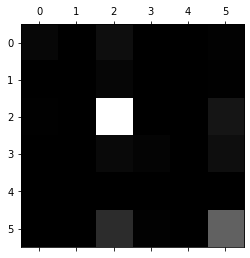

In [77]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [78]:
ordinal_encoder_pass.categories_

[array(['Annual Pass', 'Flex Pass', 'Monthly Pass', 'One Day Pass',
        'Testing', 'Walk-up'], dtype=object)]

El modelo es bueno para clasificar "Monthly Pass", que es el plan más utilizado, seguido de "Walk-up", pero falla en las demás categorías. Podría decirse que este es un modelo para identificar usuarios de "Monthly Pass".

Carguemos los datos "test_set", preparémoslo como hiciemos con el train_set.

In [138]:
test_data = pd.read_csv('test_set.csv')

/Users/adiv/opt/anaconda3/envs/dsfs/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [139]:
test_data['start_time'] = test_data['start_time'].apply(dateutil.parser.parse)
test_data['end_time'] = test_data['end_time'].apply(dateutil.parser.parse)

In [140]:
test_data['start_time'] = pd.DatetimeIndex(test_data['start_time']).to_julian_date()
test_data['end_time'] = pd.DatetimeIndex(test_data['end_time']).to_julian_date()

In [141]:
test_data['bike_id'] = pd.to_numeric(test_data['bike_id'],errors='coerce')

In [142]:
ordinal_encoder_trip_test = OrdinalEncoder()
test_data['trip_route_category'] = ordinal_encoder_trip_test.fit_transform(test_data[['trip_route_category']])

In [143]:
imputer_test = SimpleImputer(missing_values=np.nan,strategy="constant", fill_value=0)
imputer_test.fit(test_data)
test_imp = imputer_test.transform(test_data)
test_data = pd.DataFrame(test_imp, columns=test_data.columns)

In [144]:
test_data['distance'] = np.sqrt((test_data['end_lon']-test_data['start_lon'])*(test_data['end_lon']-test_data['start_lon'])
                             +(test_data['end_lat']-test_data['start_lat'])*(test_data['end_lat']-test_data['start_lat']))

In [145]:
std_scaler_test = StandardScaler()
scaled_test = std_scaler_test.fit_transform(test_data)
test_data_scaled = pd.DataFrame(scaled_test, columns=test_data.columns)

Hacemos las predicciones

In [146]:
y_test = rf_classifier.predict(test_data_scaled)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    8.4s finished


Como las categorías las tenemos en forma del Ordinal Encoder las regresamos a su clasificación original

In [147]:
y_pred = y_test.reshape(-1, 1)
y_test_cat = ordinal_encoder_pass.inverse_transform(y_pred)

In [148]:
y_test_cat

array([['Walk-up'],
       ['Walk-up'],
       ['Walk-up'],
       ...,
       ['Monthly Pass'],
       ['Walk-up'],
       ['Walk-up']], dtype=object)

In [149]:
y_test = pd.DataFrame(y_test_cat, columns=['passholder_type'])

In [150]:
test_data_new = pd.read_csv('test_set.csv')

/Users/adiv/opt/anaconda3/envs/dsfs/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [151]:
all_data = test_data_new.copy()

In [152]:
all_data['passholder_type'] = y_test

In [153]:
submission_pred = all_data[['trip_id','passholder_type']]

Finalmente exportamos a un archivos csv

In [154]:
submission_pred.to_csv('submission_pred.csv', index=False)

In [155]:
submission_pred

,trip_id,passholder_type
0,17059130,Walk-up
1,17059129,Walk-up
2,17059126,Walk-up
3,17059125,Walk-up
4,17061379,Walk-up
...,...,...
569881,179408277,Monthly Pass
569882,179408276,Monthly Pass
569883,179409877,Monthly Pass
569884,179409876,Walk-up
